# cosmoDC2 extragalactic catalog photometric redshifts
Owner:**Sam Schmidt [@sschmidt23](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@sschmidt23)**

Last Verifed to Run: **2024-03-08** (by @patricialarsen)

This notebook will show you how to access the "add-on" columns that provide the photometric redshift (photo-z) information for the extragalactic catalog (cosmoDC2_v1.1.4_image). 

__Learning objectives__: After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 extragalactic catalog (+ photo-z) via the GCR for both a template based and machine learning-based photo-z methods
  2. Understand how the photo-z data are stored / represented
  3. Look at a few examples of galaxy photo-z distributions
  
__Logistics__: This notebook is intended to be run through the Jupyter Lab NERSC interface available here: https://jupyter.nersc.gov/. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

__Other notes__: 
If you restart your kernel, or if it automatically restarts for some reason, all imports and variables will become undefined so, you will have to re-run everything.
Several photo-z catalogs were renamed starting with GCRCatalogs version 0.18.0, so check that GCRCatalogs is at least this recent when running the notebook.

This notebook will be very similar to the earlier tutorial on useing the object catalogs, so if you have worked through that example much of this will be very familiar.

A rendered version of this notebook is available at:<br>
https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/extragalactic_gcr_photoz_catalogs.nbconvert.ipynb <br>
if you want to follow along but do not wish to actually run the notebook live at NERSC.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import GCRCatalogs
from GCR import GCRQuery

## Load the catalog

Loading the cosmoDC2_v1.1.4_image catalog with photo-z add-on. The catalog name is `cosmoDC2_v1.1.4_image_with_photoz_v1`. 
This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract).  Later in the notebook we will compare these results to photo-z's produced with a machine learning based code.

This catalog is a composite of three large catalogs, so it may take a minute or more for the catalog instance to initiate.

In [32]:
%%time
cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')

CPU times: user 247 ms, sys: 130 ms, total: 378 ms
Wall time: 547 ms


## Photo-z access methods

There are several photo-z related quantities available in the catalog, a summary of which can be found on this Confluence page:
https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

There are photo-z estimates in the form of both a single number "point estimate" for each galaxy, as well as a 1D redshift probability density function (PDF) representing the posterior probability of the galaxy being at a given redshift calculated on a specific redshift grid.

There are multiple single point estimates:
1. `photoz_mode`: the mode of the redshift PDF, the highest peak of the posterior probability
2. `photoz_mean`: the weighted mean of the redshift PDF.
3. `photoz_median`: the redshift where the redshift CDF is equal to 0.5.

The redshift pdf is stored in the multi-valued column `photoz-pdf`.  The grid of redshifts at which the posterior probability is evaluated is stored in the catalog with the special attribute of `photoz_pdf_bin_centers`.  You can access this attribute for catalog cat with something like `zgrid = cat.photoz_pdf_bin_centers`

There are three additional columns that can be used as various quality flags:
1. `photoz_odds` (see Benitez 2000) is a measure of the integrated amount or probaility within a fixed distance around `photoz_mode`.  If the redshift posterior is single peaked and narrow this number will be close to 1.0, if the posterior is multi-peaked and/or broad it is likely to be smaller.  Thus, high values of `photoz_odds` can be used as an indicator of photo-z quality.
2. `photoz_mode_ml_red_chi2` is the reduced chi-squared value for the maximum likelihood estimate of the best fit template at the photo-z mode.  If this chi-squared value is very large, it indicates that none of the SED templates employed by the photo-z code were good fits to the observed colors, and thus the redshift may be suspect. High values may also occur for very bright galaxies where photometric errors are small and thus chi-squared values can grow large.

We will demonstrate access methods for several of these quantities in detail. You can notice that all the photo-z columns have a prefix of `photoz_`. 

Let's first make sure that these columns are indeed available. 

In [33]:
# uncomment the line below to see a list of *all* available quantities in the composite catalog
# print('\n'.join(sorted(cat.list_all_quantities(False))))
# or, just print the columns associated with photoz:
sorted(q for q in cat.list_all_quantities() if q.startswith('photoz_'))

['photoz_mask',
 'photoz_mean',
 'photoz_median',
 'photoz_mode',
 'photoz_mode_ml',
 'photoz_mode_ml_red_chi2',
 'photoz_odds',
 'photoz_pdf']

In [34]:
data = cat.get_quantities(['photoz_mask','photoz_pdf','photoz_mean','photoz_mode','photoz_odds','photoz_mode_ml_red_chi2','mag_i_lsst','mag_i_photoz','redshift'],
                           native_filters=['healpix_pixel==9816'])

Now, only a subset of the full cosmoDC2_v1.1.4_image and cosmoDC2_v1.1.4_small entries have photo-z's computed:  the photo-z group used a simple model to create mock photometry with 10-year depth magnitude uncertainties, added these uncertainties to the fluxes to compute "observed" magnitudes and errors (which are stored in the catalog as `mag_{ugrizy}_photoz` and `mag_err_{ugrizy}_photoz`.  Only objects with `mag_i_photoz < 26.5` had photometric redshifts calculated.<br>

For efficient loading of the chunks of the catalog, the `cosmoDC2_v1.1.4_image_with_photozs_v1` and `cosmoDC2_v1.1.4_small_with_photozs_v1` catalogs load from multiple files with different numbers of rows.  In order to properly match up the subset for which photo-z's have been computed, you will need the
`photoz_mask` quantity,and you will have to mask the cosmoDC2_v1.1.4 quantities using this mask, which is a simple boolean flag.  

As an example, redshift contains almost ten times as many entries as photo-z mode before masking, but after masking the arrays are now properly the same length, and are properly matched within the data.  In our case we will have to mask mag_i_lsst, mag_i_photoz, and redshift.

In [35]:
redshift = data['redshift']
photoz_mask = data['photoz_mask']
photoz_mode = data['photoz_mode']
mag_i_photoz = data['mag_i_photoz']
print(len(redshift))
print(len(photoz_mode))

17261509
1628434


In [36]:
redshift = redshift[photoz_mask]
mag_i_photoz = mag_i_photoz[photoz_mask]
print(len(redshift))

1628434


Let's put things in a pandas dataframe for simplicity.  Note that to load the photoz_pdf arrays, it's best to do so as a list:

In [37]:
pzdict = {'specz':redshift,'zmode':photoz_mode,'zmean':data['photoz_mean'],'odds':data['photoz_odds'],'ml_chi2':data['photoz_mode_ml_red_chi2'],
          'mag_i_photoz':mag_i_photoz}
df = pd.DataFrame(pzdict)
df['pdf']=list(data['photoz_pdf'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628434 entries, 0 to 1628433
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   specz         1628434 non-null  float64
 1   zmode         1628434 non-null  float32
 2   zmean         1628434 non-null  float32
 3   odds          1628434 non-null  float32
 4   ml_chi2       1628434 non-null  float32
 5   mag_i_photoz  1628434 non-null  float32
 6   pdf           1628434 non-null  object 
dtypes: float32(5), float64(1), object(1)
memory usage: 55.9+ MB


In [39]:
magcut = 23.6

Let's start with a simple plot of the point estimate photoz_mode vs true_redshift, and compare the full mag_i_photoz<26.5 sample to a higher S/N cut of mag_i_photoz<23.6 for both photoz_mode and photoz_mean:

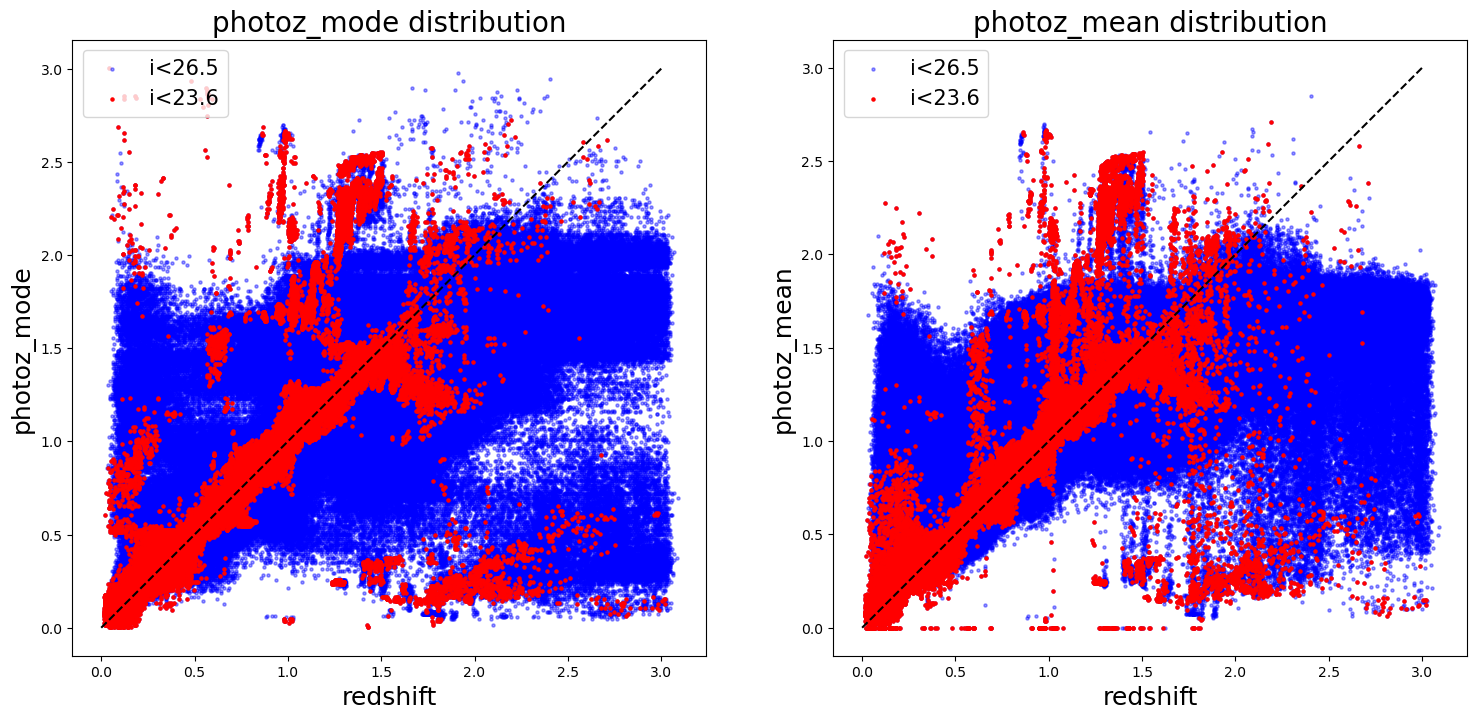

In [40]:
brightmask = (df['mag_i_photoz']<magcut)
brightdf= df[brightmask]

fig = plt.figure(figsize=(18,8))
fig = plt.subplot(121)
plt.scatter(df['specz'],df['zmode'],s=5,c='b',alpha=0.4,label="i<26.5")
plt.scatter(brightdf['specz'],brightdf['zmode'],s=5,c='r',label=f"i<{magcut}")
plt.plot([0,3],[0,3],'k--')
plt.legend(loc='upper left',fontsize=15)
plt.title("photoz_mode distribution",fontsize=20)
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mode",fontsize=18);
fig = plt.subplot(122)
plt.scatter(df['specz'],df['zmean'],s=5,c='b',alpha=0.4,label="i<26.5")
plt.scatter(brightdf['specz'],brightdf['zmean'],s=5,c='r',label=f"i<{magcut}")
plt.plot([0,3],[0,3],'k--')
plt.legend(loc='upper left',fontsize=15)
plt.title("photoz_mean distribution",fontsize=20)
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mean",fontsize=18);

We see several things: first, the photo-z's for the 25.<mag_i_photoz<26.5 (shown in blue) are not very good.  At low signal-to-noise in the magnitudes, the fits for the photometric redshifts become more and more uncertain.  For cosmology sample photo-z's, a general rule is that you want S/N in at least a few bands to be >~20 (you might be able to get away with S/N of around 10 but the photo-z's will be less reliable).  For our 10-year depth error simulation, a S/N in i-band corresponds to an i magnitude of roughly 25, and the points shown in red show a much better agreement with the specz=photo-z diagonal in the above plot, with some obvious areas of degeneracy. 

The `photoz_odds` parameter is the integrated amount of posterior probability within a fixed interval around the mode of PDF.  If the PDF is narrow and unimodal this value will be close to or equal to 1.0, if the posterior probability is broad and or multimodal the value of ODDS will decrease.  Thus, it can be used as a quality cut.  Let's plot the i<25 galaxies and highlight which subset has high values of ODDS.

Similarly, the quantity `photoz_mode_ml_red_chi2`, the reduced chi^2 of the best-fit template at the maximum likelihood redshift, may be used as a quality indicator: if the chi^2 is large even for the best template, it is an indication that none of the templates matched the photometry.  Let's plot the subset of i<25.0 galaxies with high chi^2 and examine their distribution:

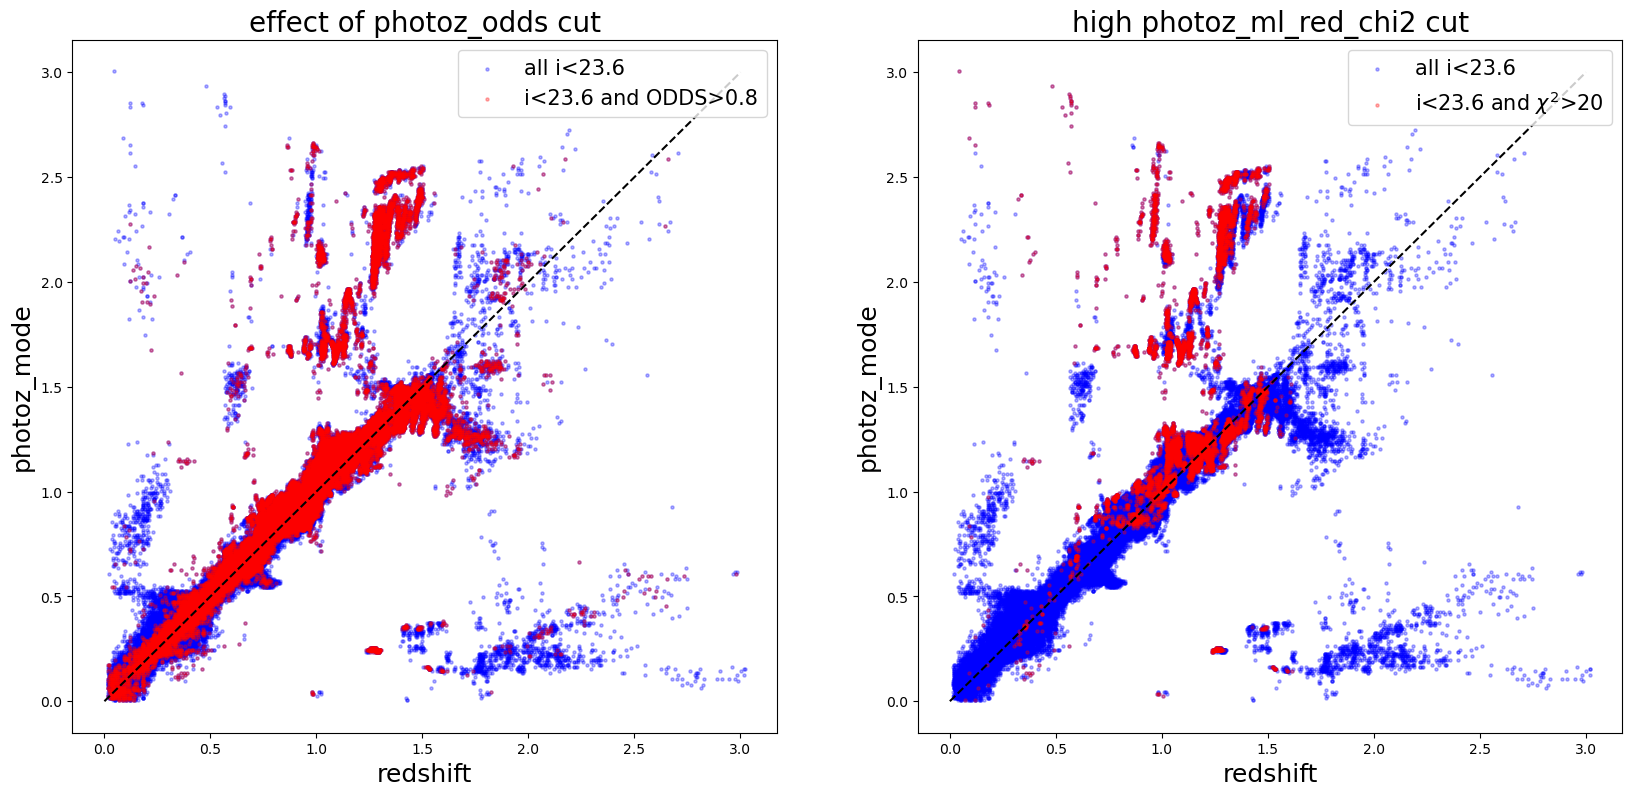

In [41]:
oddscut = (brightdf['odds']>0.99)
chicut = (brightdf['ml_chi2']>20.)

fig = plt.figure(figsize=(20,9))
plt.subplot(121)
plt.scatter(brightdf['specz'],brightdf['zmode'],s=5,c='b',alpha=0.3,label=f"all i<{magcut}")
plt.scatter(brightdf['specz'][oddscut],brightdf['zmode'][oddscut],s=5,c='r',alpha=0.3,label=f"i<{magcut} and ODDS>0.8")
plt.plot([0,3],[0,3],'k--')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mode",fontsize=18)
plt.title("effect of photoz_odds cut",fontsize=20)
plt.legend(loc='upper right',fontsize=15);
plt.subplot(122)
plt.scatter(brightdf['specz'],brightdf['zmode'],s=5,c='b',alpha=0.3,label="all i<23.6")
plt.scatter(brightdf['specz'][chicut],brightdf['zmode'][chicut],s=5,c='r',alpha=0.3,label="i<23.6 and $\chi^2$>20")
plt.plot([0,3],[0,3],'k--')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mode",fontsize=18)
plt.title("high photoz_ml_red_chi2 cut",fontsize=20)
plt.legend(loc='upper right',fontsize=15);

We see that a `photoz_odds` cut does, indeed remove a good deal of the outliers, but not all of them, and it also removes a good deal of the "good" galaxies with point estimates near the true redshift.  So, caution is warranted when using ODDS.

Galaxies with a very high value of  `photoz_mode_ml_red_chi2` are common at redshifts ~1-1.5.  Some have reasonable redshift predictions, but we notice that many of the large outlier islands have these high chi^2 values.  Many of these galaxies will still have a high ODDS value, so a combination of ODDS and photoz_ml_red_chi2 may eliminate more outliers  However, in both cases, this is at the expense of also eliminating some good galaxies, and the potential to introduce biases in overall distributions: both ODDS and chi^2 are correlated with template/SED type, so cuts on these values can affect the distribution of the galaxies selected. Keep this in mind if you attempt to use chi^2 as a mask in your samples.


We also notice slight differences between the outlier behavior from the photoz_mode vs the photoz_mean estimate.  We will look at those degeneracies and the reasons for those differences now by examining a small number of the redshift posteriors. We'll draw from the full i<26.5 sample to show more dramatic examples that can arise with low S/N, as these better illustrate the point.  Note that switching to the i<25.0 sample would result in many more unimodal and localized PDFs.

In [42]:
# NOTE: Need to set `only_use_master_attr` to False to allow accessing add-on attributes.  
#This cell is a temporary fix until this is corrected in a future gcr-catalogs version
cat.only_use_master_attr = False
zgrid = cat.photoz_pdf_bin_centers

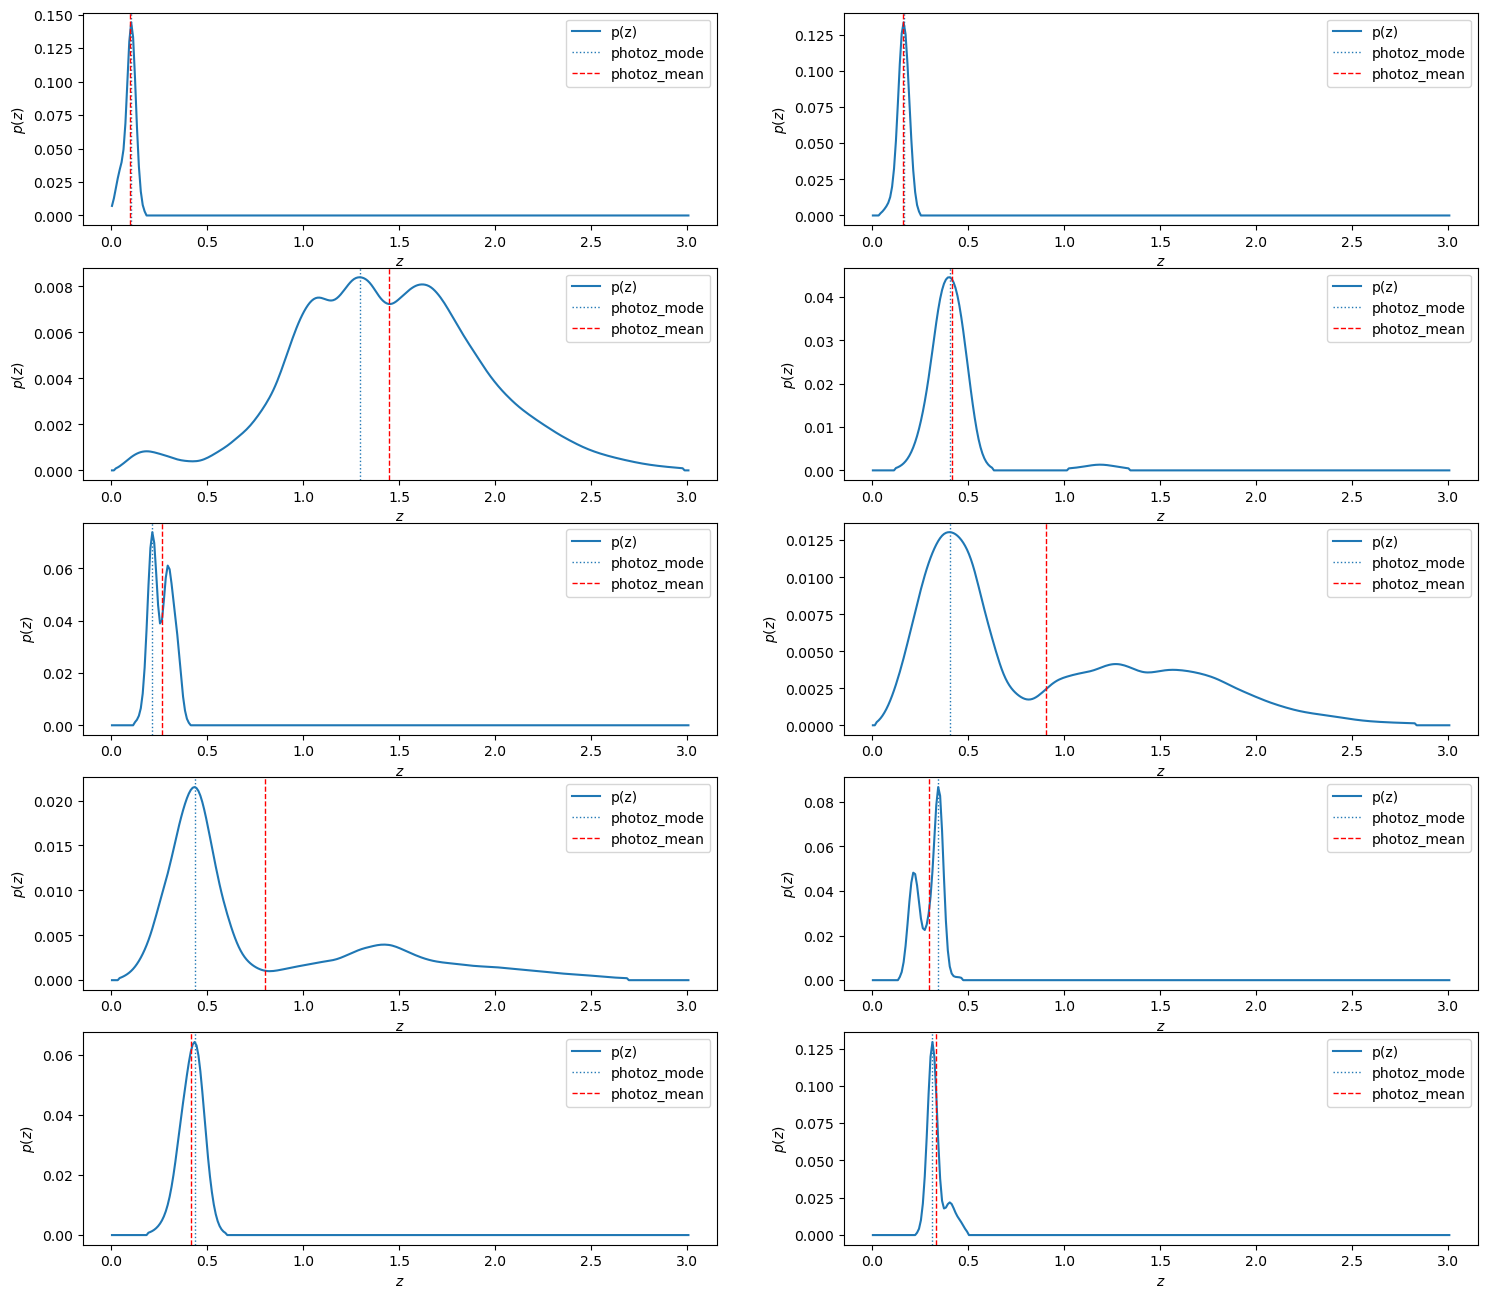

In [43]:
fig, ax = plt.subplots(5, 2, figsize=(18,16))
for pdf, z_peak, z_mean, ax_this in zip(df['pdf'][::10000], df['zmode'][::10000],
                                        df['zmean'][::10000], ax.flat):
    l = ax_this.plot(zgrid, pdf,label='p(z)');
    ax_this.axvline(z_peak, color=l[0].get_color(), ls=':', lw=1,label='photoz_mode');
    ax_this.axvline(z_mean,color='r',ls='--',lw=1,label='photoz_mean');
    ax_this.set_xlabel('$z$');
    ax_this.set_ylabel('$p(z)$');
    ax_this.legend(loc='upper right')

For narrow, unimodal, and relatively symmetric distributions like those in the top row, `photoz_mode` (the maximum value of the redshift posterior) and `photoz_mean` (the redshift-weighted average value of the photo-z posterior) estimates will be very close in value.  However, for asymmetric, broad, and multimodal distributions we see that the values of z_mode and z_mean differ, and that for bimodal distributions the z_mean estimate will fall between the two peaks.  This is why the plot of photoz_mode vs redshift shows "islands" of degeneracy in positions off of the zmode == redshift diagonal at the redshift of the secondary peak, while photoz_mode shows values spread out between the positions of the two peaks, where the mean varies depending on the relative height of the two peaks.  Neither is "correct", what the differences in the point estimates are showing is that a single number is not able to capture the complexity of the full PDF.

Speaking of full PDFs, another common use case for photo-z's is to estimate overall redshift disrtibutions for a set of objects.  A common (though technically incorrect, see papers by Alex Malz for details) way of doing this is to sum the redshift posteriors.  Let's do that for our i<25.0 sample and compare to the true redshift distribution:

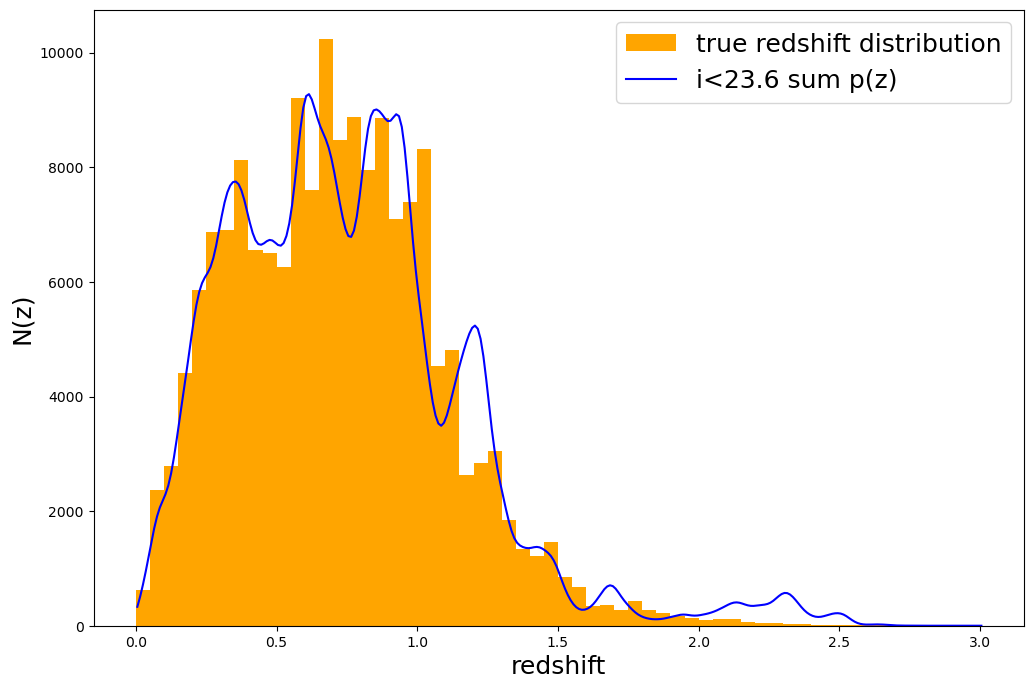

In [44]:
fig = plt.figure(figsize=(12,8))
nzsum = np.sum(brightdf['pdf'])
szbins = np.arange(0.,3.01,0.05)
plt.hist(brightdf['specz'],bins=szbins,color='orange',label='true redshift distribution')
plt.plot(zgrid,5*nzsum,c='b',label=f"i<{magcut} sum p(z)")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=18);

We see rough agreement with the true distribution with some obvious departures, and an overprediction at high redshift.  High redshift photo-z's in this catalog are known to have issues due to the way that the templates were constructed, using a method that did not optimize the UV portions of the template SEDs that shift into the LSST bands at higher redshifts. The sorts of systematics from such "template mismatch" are likely to occur in real LSST data due to the difficulty in obtaining representative data.  With the caveat of some expected systematics, let's look at an example tomographic bin, selecting galaxies based on their photoz_mode value to be between 0.4 and 0.6:

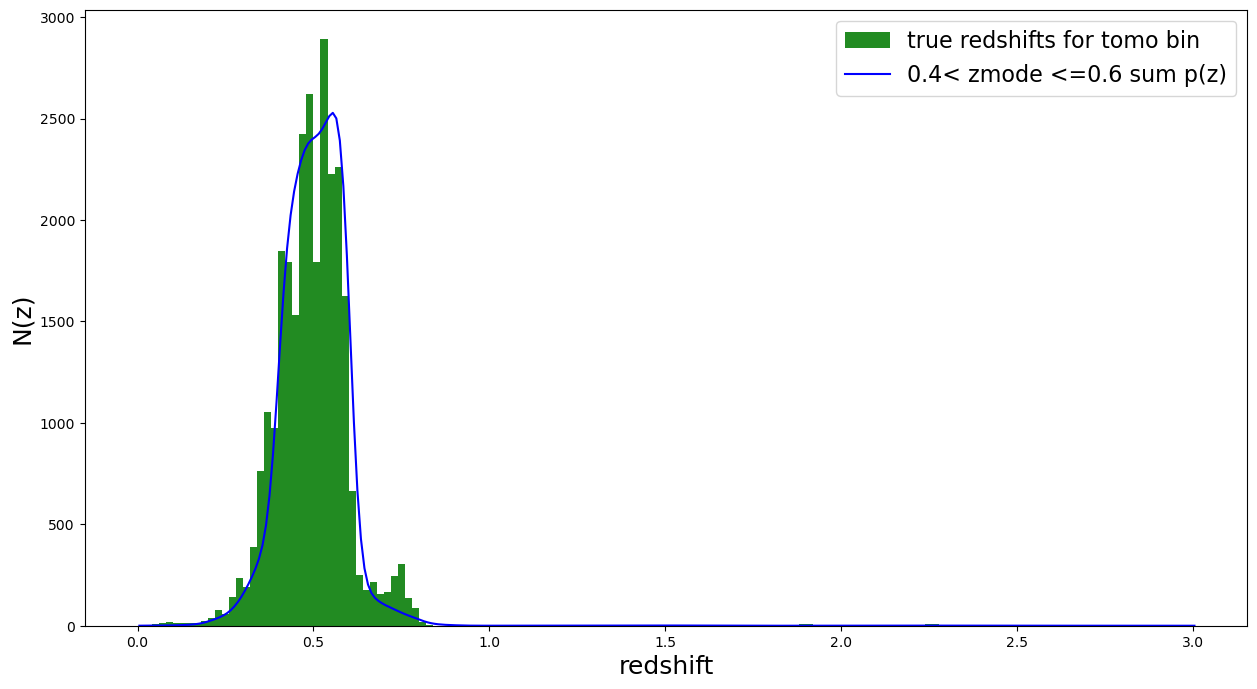

In [45]:
tomocut = ((brightdf['zmode']>0.4) & (brightdf['zmode']<=0.6))
tomonzsum = np.sum(brightdf['pdf'][tomocut])
tomobins = np.arange(0.,3.01,0.02)
fig = plt.figure(figsize=(15,8))
plt.hist(brightdf['specz'][tomocut],bins=tomobins,color='forestgreen',label='true redshifts for tomo bin')
plt.plot(zgrid,2.*tomonzsum,c='b',label='0.4< zmode <=0.6 sum p(z)')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
#plt.xlim(0.,1.25)
plt.legend(loc = 'upper right',fontsize=16);

we see some differences in the shape of the true N(z) and the summed p(z), but general agreement.  However, if we choose an area more subject to degeneracy, we will see problems.  At low redshifts near z~0.2 the Balmer Break and the Lyman Break can give similar colors in the LSST filters, and we often see confusion with higher redshifts

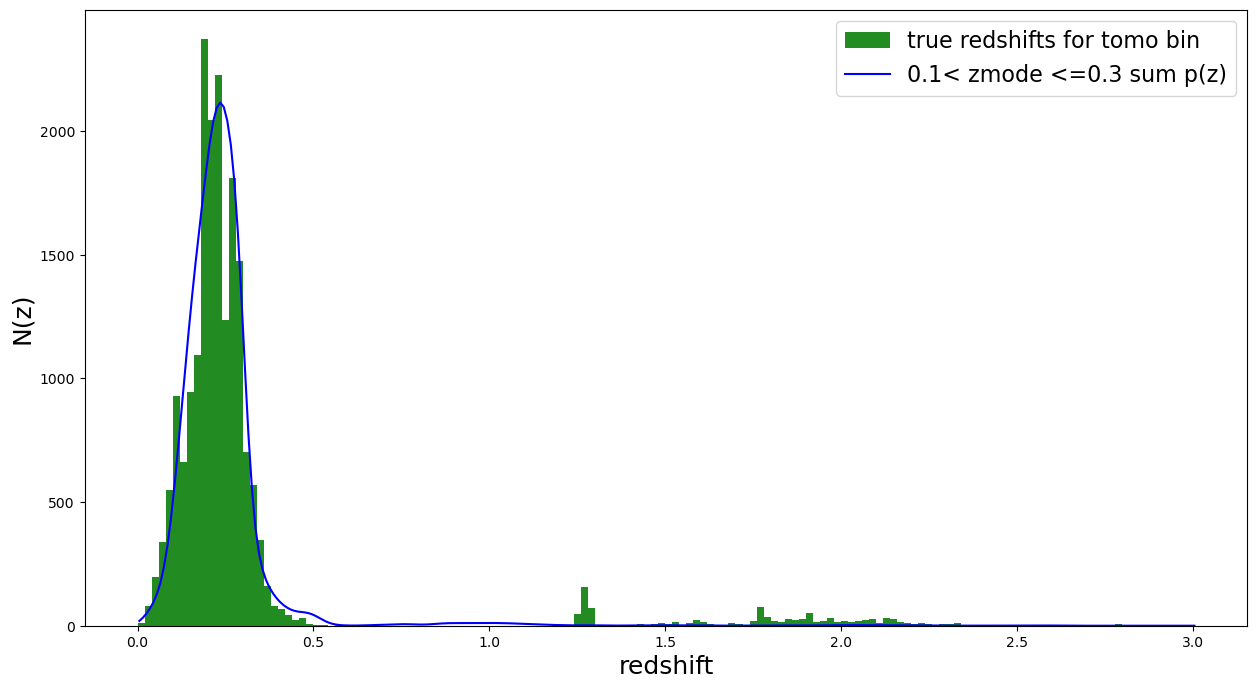

In [46]:
tomocut = ((brightdf['zmode']>0.1) & (brightdf['zmode']<=0.3))
tomonzsum = np.sum(brightdf['pdf'][tomocut])
tomobins = np.arange(0.,3.01,0.02)
fig = plt.figure(figsize=(15,8))
plt.hist(brightdf['specz'][tomocut],bins=tomobins,color='forestgreen',label='true redshifts for tomo bin')
plt.plot(zgrid,2.*tomonzsum,c='b',label='0.1< zmode <=0.3 sum p(z)')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);

While the main peak of the summed p(z) shows agreement with the true redshifts, we do see a non-insignificant contamination of high redshift objects that have been mistaken for low redshift.  This serves as a reminder that photo-z distributions, especially those with additional tomographic selections, are likely to have some biases that will need to be corrected.  The photo-z group is working on spatial correlation based methods to meaure and correct these biases for the main cosmology cases, though that is beyond the subject of this tutorial.

As we've wrapped up the first part of the demo, let's delete our pandas dataframe to free up some memory:

In [47]:
del df
del data

# FlexZBoost: Machine Learning photo-z's

Now, let's look at photo-z's computed using a machine learning algorithm, namely a conditional density estimate-based FlexZBoost (see https://projecteuclid.org/euclid.ejs/1499133755 or https://arxiv.org/abs/2001.03621 for more detail on this method).  This method was trained with a complete and representative (and thus unrealistic for real data) subsample of the DC2 data that extended to i<25.0, and provides excellent photo-z's for the i<25.0 galaxies.  The structure of the catalog is exactly the same as the one for the template-based photo-z's produced with the BPZ code that was used above.  However, as there are no templates, the `photoz_ml_red_chi2` quantity is not applicable, and has 0.0 in every entry.  Let's load the catalog and make the same `photoz_mode` and `photoz_mean` plots that we did for the BPZ photo-z's:

In [48]:
%%time
cat2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1")

CPU times: user 284 ms, sys: 122 ms, total: 406 ms
Wall time: 592 ms


In [ ]:
data2 = cat2.get_quantities(['photoz_mask','photoz_pdf','photoz_mean','photoz_mode','photoz_odds','photoz_mode_ml_red_chi2','mag_i_lsst','mag_i_photoz','redshift'],
                           native_filters=['healpix_pixel==9816'])

We need to repeat the same masking steps that we performed for the BPZ data:

In [ ]:
fz_redshift = data2['redshift']
fz_photoz_mask = data2['photoz_mask']
fz_photoz_mode = data2['photoz_mode']
fz_mag_i_photoz = data2['mag_i_photoz']
print(len(fz_redshift))
print(len(fz_photoz_mode))
fz_redshift = fz_redshift[fz_photoz_mask]
fz_mag_i_photoz = fz_mag_i_photoz[fz_photoz_mask]
print(len(fz_redshift))

And, we see that the numbers are all identical to those from BPZ, which is a good sanity check.  Now, let's put the data in a dataframe and repeat a couple of the plots:

In [ ]:
pzdict = {'specz':fz_redshift,'zmode':fz_photoz_mode,'zmean':data2['photoz_mean'],'odds':data2['photoz_odds'],'ml_chi2':data2['photoz_mode_ml_red_chi2'],
          'mag_i_photoz':fz_mag_i_photoz}
fz_df = pd.DataFrame(pzdict)
fz_df['pdf']=list(data2['photoz_pdf'])

In [ ]:
fz_df.info()

In [ ]:
brightmask = (fz_df['mag_i_photoz']<magcut)
fz_brightdf= fz_df[brightmask]

fig = plt.figure(figsize=(18,8))
fig = plt.subplot(121)
plt.scatter(fz_df['specz'],fz_df['zmode'],s=5,c='b',alpha=0.4,label="i<26.5")
plt.scatter(fz_brightdf['specz'],fz_brightdf['zmode'],s=5,c='r',label=f"i<{magcut}")
plt.plot([0,3],[0,3],'k--')
plt.legend(loc='upper left',fontsize=15)
plt.title("FlexZBoost photoz_mode distribution",fontsize=20)
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mode",fontsize=18);

fig = plt.subplot(122)
plt.scatter(fz_df['specz'],fz_df['zmean'],s=5,c='b',alpha=0.4,label="i<26.5")
plt.scatter(fz_brightdf['specz'],fz_brightdf['zmean'],s=5,c='r',label=f"i<{magcut}")
plt.plot([0,3],[0,3],'k--')
plt.legend(loc='upper left',fontsize=15)
plt.title("FlexZBoost photoz_mean distribution",fontsize=20)
plt.xlabel("redshift",fontsize=18)
plt.ylabel("photoz_mean",fontsize=18);

The bright sample looks extremely good, with almost no catastrophic outliers, while the faint galaxies extending to i<26.5 show some periodic systematics in the photoz_mode values. This is due to how FlexZBoost parameterizes the PDF as a set of 30 cosine basis functions, and at low S/N objects tend to have peaks at the nodes of these basis functions.  The training data for FlexZBoost extended down to i<25.0, so the combination of lower S/N and lack of training data below i>25.0 combines to give very unreliable photo-z's for those i>25.0 galaxies.  Another good reminder to not trust machine learning methods in regions where the data must be extrapolated beyond the training data.

But, things should look good down to i=25.0.  Let's plot the same 10 PDFs that we did for BPZ. Note that FlexZBoost uses a slightly different redshift grid than BPZ, so we'll have to grab that:

In [ ]:
# NOTE: Need to set `only_use_master_attr` to False to allow accessing add-on attributes.  
#This cell is a temporary fix until this is corrected in a future gcr-catalogs version
cat2.only_use_master_attr = False
fz_zgrid = cat2.photoz_pdf_bin_centers

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(18,16))
for pdf, z_peak, z_mean, ax_this in zip(fz_df['pdf'][::10000], fz_df['zmode'][::10000],
                                        fz_df['zmean'][::10000], ax.flat):
    l = ax_this.plot(fz_zgrid, pdf,label='p(z)');
    ax_this.axvline(z_peak, color=l[0].get_color(), ls=':', lw=1,label='photoz_mode');
    ax_this.axvline(z_mean,color='r',ls='--',lw=1,label='photoz_mean');
    ax_this.set_xlabel('$z$');
    ax_this.set_ylabel('$p(z)$');
    ax_this.legend(loc='upper right')

For 9 out of 10 we see nice compact p(z), though one galaxy has a Uniform PDF, meaning that FlexZBoost thinks this galaxy could be at any redshift.  

Now, let's look at the summed PDFs as an estimate of the redshift distribution.  

In [ ]:
fig = plt.figure(figsize=(12,8))
nzsum = np.sum(fz_brightdf['pdf'])
szbins = np.arange(-0.005,3.005,0.05)
plt.hist(fz_brightdf['specz'],bins=szbins,color='orange',label='true redshift distribution')
plt.plot(fz_zgrid,.05*nzsum,c='b',label=f"i<{magcut} sum p(z)")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.title("FlexZBoost N(z) and p(z) sum",fontsize=20)
plt.legend(loc = 'upper right',fontsize=18);

We see *very* good agreement between the summed p(z) and the true N(z)!  Machine learning methods do very well when you give them representative data, so this is not unexpected.  Now, let's show the tomographic bins:

In [ ]:
fztomocut = ((fz_brightdf['zmode']>0.4) & (fz_brightdf['zmode']<=0.6))
fz_tomonzsum = np.sum(fz_brightdf['pdf'][fztomocut])
tomobins = np.arange(-.005,3.005,0.02)
fig = plt.figure(figsize=(15,8))
plt.hist(fz_brightdf['specz'][fztomocut],bins=tomobins,color='forestgreen',label='true redshifts for tomo bin')
plt.plot(fz_zgrid,.02*fz_tomonzsum,c='b',label='0.4< zmode <=0.6 sum p(z)')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
#plt.xlim(0.,1.25)
plt.legend(loc = 'upper right',fontsize=16);

In [ ]:
fztomocut = ((fz_brightdf['zmode']>0.1) & (fz_brightdf['zmode']<=0.3))
fz_tomonzsum = np.sum(fz_brightdf['pdf'][fztomocut])
tomobins = np.arange(-.005,3.005,0.02)
fig = plt.figure(figsize=(15,8))
plt.hist(fz_brightdf['specz'][fztomocut],bins=tomobins,color='forestgreen',label='true redshifts for tomo bin')
plt.plot(fz_zgrid,.02*fz_tomonzsum,c='b',label='0.1< zmode <=0.3 sum p(z)')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
#plt.xlim(0.,1.25)
plt.legend(loc = 'upper right',fontsize=16);

We see that both tomographic bins do a relatively good job at approximating the true redshift distribution, and neither has a significant fraction of outliers.

So, that is a summary of some simple operations that you can perform with the extragalactic photometric redshift catalogs.  For both sets we recommend not using the photo-z's for mag_i_photoz < 25.0 due to both lack of training data and low S/N.  